<a href="https://colab.research.google.com/github/freyaabbi/GPU-Based-N-Body-Simulation-in-Astrophysics/blob/main/N_Body_Simulations_in_Astrophysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install numba pyopencl



In [12]:
import time
import math
import numpy as np
from functools import partial


# small RNG seed helper
# small RNG seed helper
def init_particles(N, seed=42, box=1.0):
    rng = np.random.RandomState(seed)
    pos = rng.uniform(-box, box, size=(N, 3)).astype(np.float32)
    vel = rng.normal(0, 0.01, size=(N, 3)).astype(np.float32)
    mass = np.ones(N, dtype=np.float32)
    return pos, vel, mass



# energy calculation for sanity
def kinetic_energy(vel, mass):
    return 0.5 * (mass[:,None] * (vel**2)).sum()

In [7]:
def forces_numpy(pos, mass, softening=1e-4):
    N = pos.shape[0]
    accel = np.zeros_like(pos, dtype=np.float32)
    for i in range(N):
        rij = pos - pos[i]  # (N,3)
        dist2 = np.sum(rij * rij, axis=1) + softening
        invdist3 = dist2 ** -1.5
        invdist3[i] = 0.0  # zero self-force
        scalar = mass * invdist3
        a = (scalar[:, None] * rij).sum(axis=0)
        accel[i] = a
    return accel



# timestep integrator (simple symplectic Euler)
def step_numpy(pos, vel, mass, dt):
    a = forces_numpy(pos, mass)
    vel += a * dt
    pos += vel * dt
    return pos, vel

In [6]:
from numba import njit, prange


@njit(parallel=True, fastmath=True)
def forces_numba_cpu(pos, mass, softening=1e-4):
    N = pos.shape[0]
    accel = np.zeros_like(pos)
    for i in prange(N):
        ax = 0.0
        ay = 0.0
        az = 0.0
        xi = pos[i,0]
        yi = pos[i,1]
        zi = pos[i,2]
        for j in range(N):
            if i == j:
                continue
            dx = pos[j,0] - xi
            dy = pos[j,1] - yi
            dz = pos[j,2] - zi
            dist2 = dx*dx + dy*dy + dz*dz + softening
            invdist3 = dist2 ** -1.5
            s = mass[j] * invdist3
            ax += s * dx
            ay += s * dy
            az += s * dz
        accel[i,0] = ax
        accel[i,1] = ay
        accel[i,2] = az
    return accel
def step_numba_cpu(pos, vel, mass, dt):
    a = forces_numba_cpu(pos, mass)
    for i in range(pos.shape[0]):
        vel[i, 0] += a[i, 0] * dt
        vel[i, 1] += a[i, 1] * dt
        vel[i, 2] += a[i, 2] * dt
        pos[i, 0] += vel[i, 0] * dt
        pos[i, 1] += vel[i, 1] * dt
        pos[i, 2] += vel[i, 2] * dt
    return pos, vel




In [5]:
try:
    from numba import cuda
    cuda_available = cuda.is_available()
except Exception:
    cuda_available = False


if cuda_available:

    @cuda.jit
    def gpu_forces_kernel(pos, mass, out, softening):
        i = cuda.grid(1)
        N = pos.shape[0]
        if i >= N:
            return
        xi = pos[i, 0]
        yi = pos[i, 1]
        zi = pos[i, 2]
        ax = 0.0
        ay = 0.0
        az = 0.0
        for j in range(N):
            if i == j:
                continue
            dx = pos[j, 0] - xi
            dy = pos[j, 1] - yi
            dz = pos[j, 2] - zi
            dist2 = dx * dx + dy * dy + dz * dz + softening
            invdist3 = dist2 ** -1.5
            s = mass[j] * invdist3
            ax += s * dx
            ay += s * dy
            az += s * dz
        out[i, 0] = ax
        out[i, 1] = ay
        out[i, 2] = az


    def forces_numba_cuda(pos_h, mass_h, softening=1e-4):
        # host arrays -> device arrays
        N = pos_h.shape[0]
        pos_d = cuda.to_device(pos_h)
        mass_d = cuda.to_device(mass_h)
        out_d = cuda.device_array_like(pos_h)
        threadsperblock = 128
        blockspergrid = (N + threadsperblock - 1) // threadsperblock
        gpu_forces_kernel[blockspergrid, threadsperblock](pos_d, mass_d, out_d, softening)
        return out_d.copy_to_host()

else:
    def forces_numba_cuda(*args, **kwargs):
        raise RuntimeError('CUDA not available in this runtime')


In [10]:
def bench(func, *args, niter=3):
    # warmup
    for _ in range(1):
        func(*args)
    t0 = time.time()
    for _ in range(niter):
        func(*args)
    t = (time.time() - t0) / niter
    return t


# interactions/sec: N*(N-1) interactions per force evaluation in naive O(N^2)
def interactions_per_sec(N, sec_per_eval):
    return (N * (N - 1)) / sec_per_eval


# approximate GFLOPS estimate: depends on flops per interaction (paper: ~19 flops/interaction for GA)
FLOPS_PER_INTERACTION = 19.0


def gflops(N, sec_per_eval):
    return (interactions_per_sec(N, sec_per_eval) * FLOPS_PER_INTERACTION) / 1e9


In [21]:
# --- 🔧 FIX: CUDA PTX version mismatch in Colab ---
import os

# Let NVIDIA driver handle PTX compilation
os.environ["NUMBA_CUDA_USE_NVIDIA_BINDING"] = "1"

# Enable compatibility mode between minor versions of CUDA toolkit and driver
os.environ["NUMBA_CUDA_ENABLE_MINOR_VERSION_COMPATIBILITY"] = "1"

# Disable internal PTX linker that triggers unsupported PTX version
os.environ["NUMBA_CUDA_USE_PTX_LAUNCH"] = "0"

# Optionally, force a compatible architecture for PTX generation
os.environ["NUMBA_CUDA_DEFAULT_PTX_TARGET"] = "sm_75"   # Safe for most Colab GPUs


In [1]:
import numba
from numba import cuda

print("✅ Numba version:", numba.__version__)
print("✅ CUDA runtime version:", cuda.runtime.get_version())
print("✅ Device:", cuda.get_current_device().name)


✅ Numba version: 0.62.1
✅ CUDA runtime version: (12, 6)
✅ Device: b'Tesla T4'


In [14]:
!pip install -q cupy-cuda12x


In [15]:
import cupy as cp
import time

# CuPy GPU kernel (runs fine on Colab)
nbody_kernel = cp.RawKernel(r'''
extern "C" __global__
void nbody_force(const float* pos,
                 const float* mass,
                 float* acc,
                 int N, float softening)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i >= N) return;
    float xi = pos[3*i + 0];
    float yi = pos[3*i + 1];
    float zi = pos[3*i + 2];
    float ax = 0.0f, ay = 0.0f, az = 0.0f;
    for (int j = 0; j < N; ++j) {
        if (i == j) continue;
        float dx = pos[3*j + 0] - xi;
        float dy = pos[3*j + 1] - yi;
        float dz = pos[3*j + 2] - zi;
        float dist2 = dx*dx + dy*dy + dz*dz + softening;
        float inv = rsqrtf(dist2);
        float inv3 = inv * inv * inv;
        float s = mass[j] * inv3;
        ax += s * dx;
        ay += s * dy;
        az += s * dz;
    }
    acc[3*i + 0] = ax;
    acc[3*i + 1] = ay;
    acc[3*i + 2] = az;
}
''', 'nbody_force')


def forces_cupy(pos, mass, softening=1e-4):
    N = pos.shape[0]
    acc = cp.zeros_like(pos)
    threads = 256
    blocks = (N + threads - 1) // threads
    nbody_kernel((blocks,), (threads,),
                 (pos.ravel(), mass, acc.ravel(),
                  np.int32(N), np.float32(softening)))
    return acc


def step_cupy(pos, vel, mass, dt):
    acc = forces_cupy(pos, mass)
    vel += acc * dt
    pos += vel * dt
    return pos, vel


def bench_gpu(func, *args, niter=3):
    cp.cuda.Device(0).synchronize()
    t0 = time.time()
    for _ in range(niter):
        func(*args)
        cp.cuda.Device(0).synchronize()
    return (time.time() - t0) / niter


In [16]:
N = 1024
pos = cp.asarray(np.random.uniform(-1, 1, (N, 3)).astype(np.float32))
vel = cp.asarray(np.random.normal(0, 0.01, (N, 3)).astype(np.float32))
mass = cp.ones(N, dtype=np.float32)

print("Running CuPy GPU benchmark...")
t_gpu = bench_gpu(lambda: forces_cupy(pos, mass), niter=3)
interactions = N * (N - 1)
gflops = (interactions * 19.0) / (t_gpu * 1e9)
print(f"CuPy GPU time: {t_gpu:.4f}s, {interactions/t_gpu:.2e} interactions/s, ~{gflops:.3f} GFLOPS")


Running CuPy GPU benchmark...
CuPy GPU time: 0.0253s, 4.15e+07 interactions/s, ~0.788 GFLOPS


In [17]:
sizes = [256, 512, 1024, 2048]
results = []

for N in sizes:
    print(f"\n🔹 N = {N}")
    pos_np, vel_np, mass_np = init_particles(N)

    # CPU benchmark
    t_cpu = bench(lambda: forces_numba_cpu(pos_np, mass_np), niter=3)

    # GPU benchmark
    pos_cp = cp.asarray(pos_np)
    mass_cp = cp.asarray(mass_np)
    t_gpu = bench_gpu(lambda: forces_cupy(pos_cp, mass_cp), niter=3)

    speedup = t_cpu / t_gpu
    results.append((N, t_cpu, t_gpu, speedup))

import pandas as pd
df = pd.DataFrame(results, columns=["N", "CPU_time(s)", "GPU_time(s)", "Speedup"])
df



🔹 N = 256

🔹 N = 512

🔹 N = 1024

🔹 N = 2048


,N,CPU_time(s),GPU_time(s),Speedup
0,256,0.001028,0.000166,6.200959
1,512,0.002052,0.000200,10.263116
2,1024,0.010817,0.000355,30.510200
3,2048,0.042350,0.000620,68.319359


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['N'].plot(kind='hist', bins=20, title='N')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['CPU_time(s)'].plot(kind='hist', bins=20, title='CPU_time(s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['GPU_time(s)'].plot(kind='hist', bins=20, title='GPU_time(s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='N', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='N', y='CPU_time(s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='CPU_time(s)', y='GPU_time(s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='GPU_time(s)', y='Speedup', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['N']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'N'}, axis=1)
              .sort_values('N', ascending=True))
  xs = counted['N']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('N', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('N')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['CPU_time(s)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'CPU_time(s)'}, axis=1)
              .sort_values('CPU_time(s)', ascending=True))
  xs = counted['CPU_time(s)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('CPU_time(s)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CPU_time(s)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['GPU_time(s)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'GPU_time(s)'}, axis=1)
              .sort_values('GPU_time(s)', ascending=True))
  xs = counted['GPU_time(s)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('GPU_time(s)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('GPU_time(s)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['N'].plot(kind='line', figsize=(8, 4), title='N')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['CPU_time(s)'].plot(kind='line', figsize=(8, 4), title='CPU_time(s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['GPU_time(s)'].plot(kind='line', figsize=(8, 4), title='GPU_time(s)')
plt.gca().spines[['top', 'right']].set_visible(False)

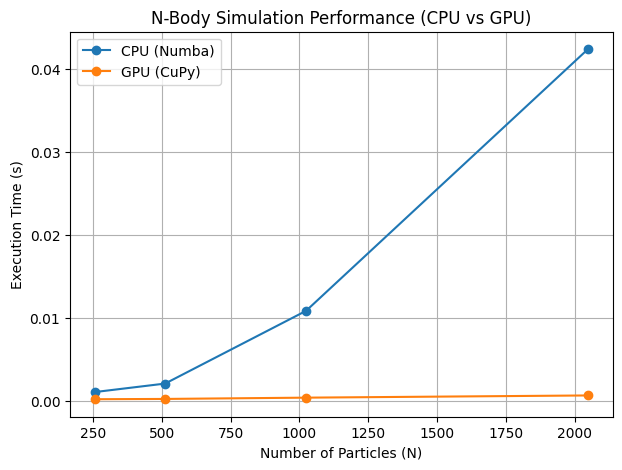

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(df["N"], df["CPU_time(s)"], 'o-', label="CPU (Numba)")
plt.plot(df["N"], df["GPU_time(s)"], 'o-', label="GPU (CuPy)")
plt.xlabel("Number of Particles (N)")
plt.ylabel("Execution Time (s)")
plt.title("N-Body Simulation Performance (CPU vs GPU)")
plt.legend()
plt.grid(True)
plt.show()


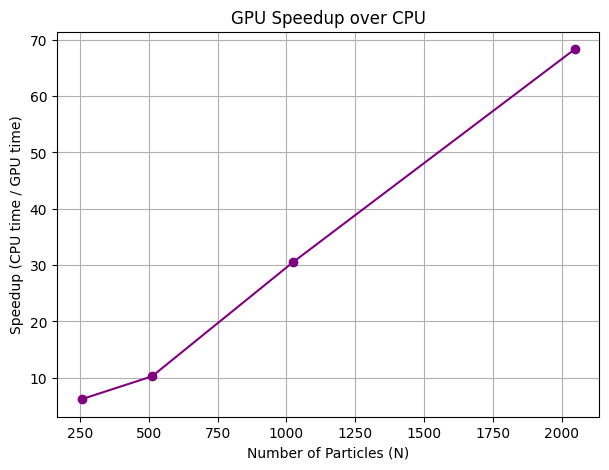

In [20]:
plt.figure(figsize=(7,5))
plt.plot(df["N"], df["Speedup"], 'o-', color='purple')
plt.xlabel("Number of Particles (N)")
plt.ylabel("Speedup (CPU time / GPU time)")
plt.title("GPU Speedup over CPU")
plt.grid(True)
plt.show()



In [22]:
import cupy as cp
import numpy as np

def init_particles_cp(N, seed=42, box=1.0):
    rng = np.random.default_rng(seed)
    pos = rng.uniform(-box, box, (N, 3)).astype(np.float32)
    vel = rng.normal(0, 0.01, (N, 3)).astype(np.float32)
    mass = np.ones(N, dtype=np.float32)
    # move arrays to GPU
    return cp.asarray(pos), cp.asarray(vel), cp.asarray(mass)

print("✅ init_particles_cp() is ready")


✅ init_particles_cp() is ready


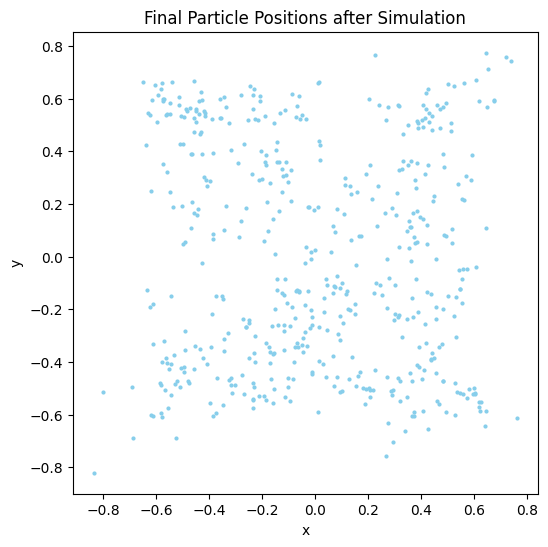

In [23]:
def run_simulation(N=512, steps=50, dt=1e-3):
    pos, vel, mass = init_particles_cp(N)
    for _ in range(steps):
        pos, vel = step_cupy(pos, vel, mass, dt)
    return pos

final_pos = run_simulation(N=512)
pos_np = cp.asnumpy(final_pos)

plt.figure(figsize=(6,6))
plt.scatter(pos_np[:,0], pos_np[:,1], s=4, color='skyblue')
plt.title("Final Particle Positions after Simulation")
plt.xlabel("x"); plt.ylabel("y")
plt.show()


In [24]:
def gflops(N, time_s):
    FLOPS_PER_INTERACTION = 19.0  # from Elsen et al. (2007)
    interactions = N * (N - 1)
    return (interactions * FLOPS_PER_INTERACTION) / (time_s * 1e9)

df["CPU_GFLOPS"] = [gflops(N, t) for N, t in zip(df["N"], df["CPU_time(s)"])]
df["GPU_GFLOPS"] = [gflops(N, t) for N, t in zip(df["N"], df["GPU_time(s)"])]

display(df.round(4))


,N,CPU_time(s),GPU_time(s),Speedup,CPU_GFLOPS,GPU_GFLOPS
0,256,0.0010,0.0002,6.2010,1.2071,7.4853
1,512,0.0021,0.0002,10.2631,2.4223,24.8608
2,1024,0.0108,0.0004,30.5102,1.8401,56.1407
3,2048,0.0424,0.0006,68.3194,1.8808,128.4955
